# Random Forest feature importance streamflow wflow

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.base import clone 

from scipy.stats import ks_2samp
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from functools import partial
from tqdm.notebook import trange, tqdm

import matplotlib.pyplot as plt
from pathlib import Path

## Set Paths

In [2]:
# Set paths
ROOT = Path('/gpfs/work1/0/wtrcycle/users/jaerts/model_refinement_pub/')
RESULTS = f'{ROOT}/results/new/'

## Load Data

In [3]:
# Load Dataframe
df = pd.read_csv(f'{RESULTS}/rf_feature_selection/rf_wflow_pcrglob_soil_moisture_camels_attrs.csv', index_col='basin_id')

df.loc[df['RRMSE_sm_wflow'] > 10, 'RRMSE_sm_wflow'] = 10
df.loc[df['RRMSE_sm_pcrglob'] > 10, 'RRMSE_sm_pcrglob'] = 10
df['delta'] = df.RRMSE_sm_wflow - df.RRMSE_sm_pcrglob
df = df.dropna()



## Creat Train and Test set

In [4]:
def create_folds(df, variable, n_s=10, n_grp=10):
    df = df.reset_index()
    df['Fold'] = -1
    skf = StratifiedKFold(n_splits=n_s, shuffle=True, random_state=1)
    df['grp'] = pd.cut(df[variable], n_grp, labels=False)
    target = df.grp
    for fold_no, (t, v) in enumerate(skf.split(target, target)):
        df.loc[v, 'Fold'] = fold_no
    return df

# create folds
n_groups = 25
n_folds = 10

df = create_folds(df, variable='delta', n_s=n_folds, n_grp=n_groups)

/home/jaerts/miniconda3/envs/wflow_state_flux/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


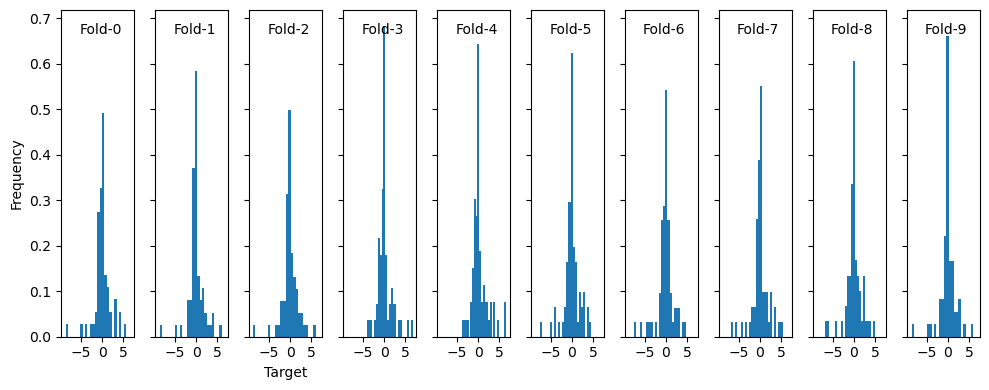

Fold 0 vs 1: KstestResult(statistic=0.078125, pvalue=0.9907746509475145)
Fold 0 vs 2: KstestResult(statistic=0.078125, pvalue=0.9907746509475145)
Fold 0 vs 3: KstestResult(statistic=0.078125, pvalue=0.9907746509475145)
Fold 0 vs 4: KstestResult(statistic=0.078125, pvalue=0.9907746509475145)
Fold 0 vs 5: KstestResult(statistic=0.09375, pvalue=0.9439990378651473)
Fold 0 vs 6: KstestResult(statistic=0.10069444444444445, pvalue=0.8589398655347046)
Fold 0 vs 7: KstestResult(statistic=0.05803571428571429, pvalue=0.9993660456384517)
Fold 0 vs 8: KstestResult(statistic=0.13219246031746032, pvalue=0.5765256584813276)
Fold 0 vs 9: KstestResult(statistic=0.07390873015873016, pvalue=0.9856523901392108)


In [5]:
fig, axs = plt.subplots(1, 10, sharex=True, sharey=True, figsize=(10,4))
for i, ax in enumerate(axs):
    ax.hist(df[df.Fold == i]['delta'], bins=n_groups, density=True, label=f'Fold-{i}')
    if i == 0:
        ax.set_ylabel('Frequency')
    if i == 2:
        ax.set_xlabel("Target")
    ax.legend(frameon=False, handlelength=0)
plt.tight_layout()
plt.show()

for fold in np.sort(df.Fold.unique())[1:]:
    print(f'Fold 0 vs {fold}:', ks_2samp(df.loc[df.Fold==0,'delta'], df.loc[df.Fold==fold,'delta']))

## Define Target and Features

In [6]:
X = df.drop(columns=['basin_id', 'RRMSE_sm_wflow','RRMSE_sm_pcrglob','delta'])
y = df['delta']

## Load Hyper Parameters

In [7]:
trials_df = pd.read_csv(f'{RESULTS}/rf_feature_selection/hyper_parameters/rf_hyperparam_delta_wp_soil_moisture.csv')
trials_df.sort_values('loss').iloc[0]

Unnamed: 0       22.0000
max_depth         8.0000
max_features      0.9000
max_samples       0.8000
n_estimators    110.0000
random_state    500.0000
loss              0.8115
Name: 22, dtype: float64

## Select best hyper parameters and create model

In [8]:
rf = RandomForestRegressor(
    n_estimators=int(trials_df.sort_values('loss').iloc[0].n_estimators),
    max_depth=int(trials_df.sort_values('loss').iloc[0].max_depth),
    max_features=float(trials_df.sort_values('loss').iloc[0].max_features),
    max_samples=float(trials_df.sort_values('loss').iloc[0].max_samples),
    random_state=int(trials_df.sort_values('loss').iloc[0].random_state),
    n_jobs=10)

# Drop column feature importance

## Complete dataset standardized Train only

In [9]:
def imp_df(folds, features, importances,benchmark_scores):
    data = {
        'Fold' : folds,
        'Feature': features,
        'Importance': importances,
        'Benchmark Score': benchmark_scores
    }
    df = pd.DataFrame(data) \
        .set_index('Feature') \
        .sort_values('Importance', ascending=False)

    return df

def drop_col_feat_imp(model, X, y):
    # drop column feature importance
    # https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e
    
    # list for storing feature importances
    folds = []
    features = []
    benchmark_scores = []
    importances = []
        
    # Loop folds, leave 1 out
    losses = []
    for k in range(n_folds):
        X_test = X.loc[X.Fold==k]
        X_test = X_test.drop(columns=['Fold','grp'])

        y_test = y.loc[X_test.index]

        X_train = X.drop(X_test.index)
        X_train = X_train.drop(columns=['Fold','grp'])

        y_train = y.loc[X_train.index]
        
        # Standardize data
        # https://towardsdatascience.com/how-data-normalization-affects-your-random-forest-algorithm-fbc6753b4ddf
        scaler = StandardScaler()
        X_train_scale = scaler.fit_transform(X_train)
        X_test_scale = scaler.transform(X_test)
        
        y_train_scale = scaler.fit_transform(y_train.values.reshape(-1,1)).ravel()
        y_test_scale = scaler.transform(y_test.values.reshape(-1,1)).ravel()
        
        # Clone model 
        model_clone = clone(model)
        
        # Fit the model on the training dataset and calculate the benchmark score 
        model_clone.fit(X_train_scale, y_train_scale)
        benchmark_score = model_clone.score(X_test_scale, y_test_scale)
        print(f'Fold {k+1}: Benchmark Score: {benchmark_score}')
        
        # iterating over all columns and storing feature importance (difference between benchmark and new model)
        for i, col in enumerate(X_train.columns):
            print(f'Fold {k+1}: {i} of {len(X_train.columns)} columns', end='\r')

            # Clone model
            model_clone_drop = clone(model)

            # Drop column
            X_train_drop = X_train.drop(col, axis = 1)
            X_test_drop = X_test.drop(col, axis = 1)

            # Standardize data
            scaler = StandardScaler()
            X_train_scale = scaler.fit_transform(X_train_drop)
            X_test_scale = scaler.transform(X_test_drop)

            # Train model
            model_clone.fit(X_train_scale, y_train_scale)

            # Calculate score
            drop_col_score = model_clone.score(X_test_scale, y_test_scale)

            # Append importance
            folds.append(k)
            features.append(col)
            benchmark_scores.append(benchmark_score)
            importances.append(benchmark_score - drop_col_score)
            
    # Create output dataframe
    importances_df = imp_df(folds, features, importances, benchmark_scores)        
     
    return importances_df

In [10]:
importances_df = drop_col_feat_imp(rf, X, y)
importances_df.to_csv(f'{RESULTS}/rf_feature_selection/feature_importance/fold_feature_importance_rf_delta_wp_soil_moisture.csv')
importances_df = importances_df.drop(columns=['Fold'])
importances_df = importances_df.groupby(importances_df.index).mean()
importances_df.to_csv(f'{RESULTS}/rf_feature_selection/feature_importance/feature_importance_rf_delta_wp_soil_moisture.csv')

Fold 1: Benchmark Score: 0.060592604901972824
Fold 2: Benchmark Score: 0.18768400387168038
Fold 3: Benchmark Score: 0.09236021125765925
Fold 4: Benchmark Score: 0.3518140497535408
Fold 5: Benchmark Score: 0.22710457816424545
Fold 6: Benchmark Score: 0.20219210254115494
Fold 7: Benchmark Score: 0.3395517764179996
Fold 8: Benchmark Score: 0.22668338741208638
Fold 9: Benchmark Score: 0.33524355089611624
Fold 10: Benchmark Score: 0.08492667410090504


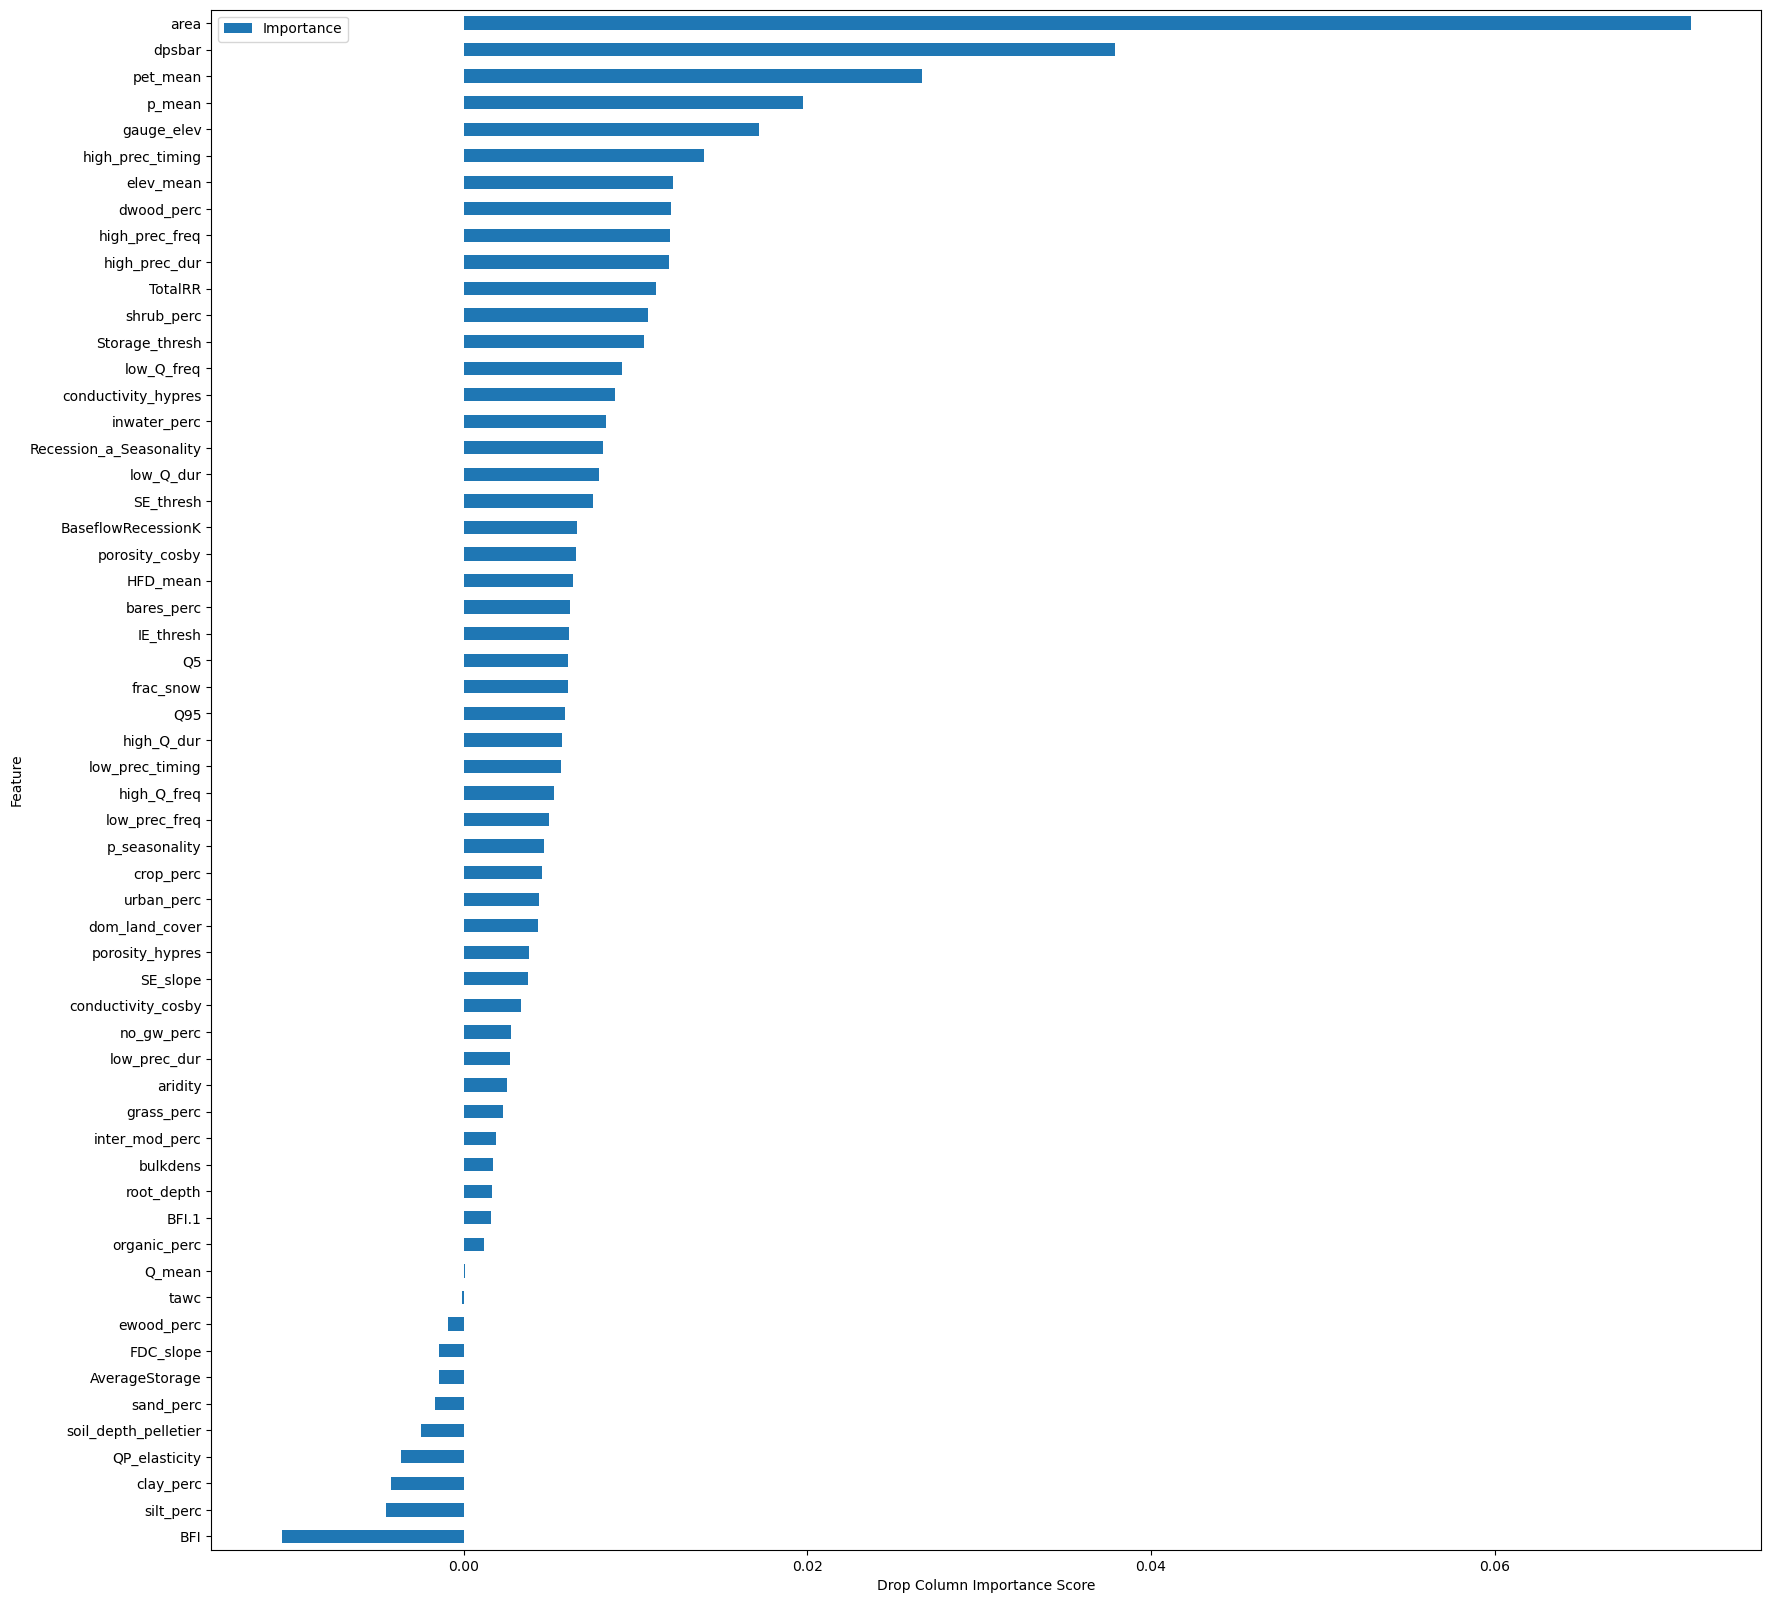

In [11]:
importances_df = importances_df.drop(columns=['Benchmark Score'])
importances_df.sort_values(by=['Importance'], ascending=True).plot(kind='barh', figsize=(20, 20)).set(xlabel="Drop Column Importance Score")
plt.savefig("/gpfs/home6/jaerts/model_refinement_master/temp/soil_moisture_delta.png")